In [2]:
%config Completer.use_jedi = False

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
from src.echonet_dataset import EchoNetDynamicDataset

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [3]:
batch_size = 4
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [4]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", raise_for_es_ed=False, subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

100%|██████████| 16/16 [00:01<00:00, 14.28it/s]


In [5]:
def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)

In [43]:
model_save_path = "save_models/R2plus1DMotionSegNet_model_tmp.pth"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


In [44]:
test_pat_index = np.random.randint(len(test_dataset))

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

### Get all possible 32-Frame Clips that covers ED-ES

In [45]:
possible_starts = get_all_possible_start_points(ed_index, es_index, video.shape[1], clip_length=32)
possible_starts

array([102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118])

### Segment All 32-Frame Clips

In [46]:
segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))

for start in possible_starts:
    one_clip = np.expand_dims(video[:, start: start + 32], 0)
    segmentation_output, motion_output = model(torch.Tensor(one_clip))
    segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
    motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
segmentation_outputs = segmentation_outputs[1:]
motion_outputs = motion_outputs[1:]

In [47]:
segmentations = np.argmax(segmentation_outputs, axis=1)
segmentations.shape

(17, 32, 112, 112)

### Plot the Segmented LV Sizes (in pixels) with Scatter plots
Start symbols mark the beginning of the 32-Frame video clips.

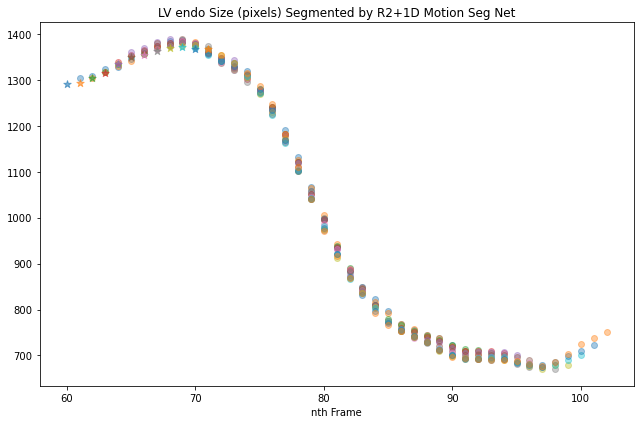

In [12]:
fig, ax = plt.subplots(1, figsize=(9, 6))
for i in range(len(possible_starts)):
    lv_sizes = np.sum(segmentations[i], axis=(1, 2))
    scatter = ax.scatter(np.arange(possible_starts[i] + 1, possible_starts[i] + 32), lv_sizes[1:], alpha=0.4)
    color = scatter.get_facecolors()[0]
    ax.scatter(possible_starts[i], lv_sizes[0], color=color, alpha=0.6, s=60, marker="*")


ax.set_title("LV endo Size (pixels) Segmented by R2+1D Motion Seg Net")
ax.set_xlabel("nth Frame")

plt.tight_layout()
plt.show()

# Full batch of possible random clips
# LV endo sizes cloud

### Plot the Segmented LV Sizes (in pixels) with line plots
Start symbols mark the beginning of the 32-Frame video clips.

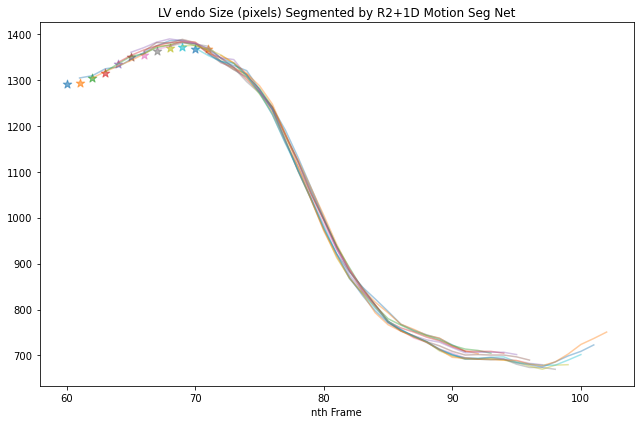

In [13]:
fig, ax = plt.subplots(1, figsize=(9, 6))
for i in range(len(possible_starts)):
    lv_sizes = np.sum(segmentations[i], axis=(1, 2))
    scatter = ax.plot(np.arange(possible_starts[i] + 1, possible_starts[i] + 32), lv_sizes[1:], alpha=0.4)
    color = scatter[0].get_color()
    ax.scatter(possible_starts[i], lv_sizes[0], color=color, alpha=0.6, s=80, marker="*")

ax.set_title("LV endo Size (pixels) Segmented by R2+1D Motion Seg Net")
ax.set_xlabel("nth Frame")

# plt.legend(loc="lower right", fontsize=14, ncol=2)
plt.tight_layout()
plt.show()

# Full batch of possible random clips
# LV endo sizes cloud

### Divide a Test Patient's Echo videos into consecutive 32-Frame clips

In [49]:
video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

interpolate_last = True

consecutive_clips = divide_to_consecutive_clips(video, interpolate_last=interpolate_last)
consecutive_clips.shape

(5, 3, 32, 112, 112)

### Segment the Consecutive 32-Frame video clips
If the video length is not a multiple of 32 (32-frame video clips), then interpolate the video so its length equals to the nearest multiple of 32.

For example, a video with length 88 will be interpolated to 96, and a video with length 72 will be interpolated to 64.

In [50]:
segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))

for i in range(consecutive_clips.shape[0]):
    one_clip = np.expand_dims(consecutive_clips[i], 0)
    segmentation_output, motion_output = model(torch.Tensor(one_clip))
    segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
    motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
segmentation_outputs = segmentation_outputs[1:]
motion_outputs = motion_outputs[1:]

In [51]:
segmentations = np.argmax(segmentation_outputs, axis=1)
segmentations.shape

(5, 32, 112, 112)

### If the video length is not a multiple of 32 and has been interpolated during segmentation
then interpolate the lv sizes results back to the original length of the input video

In [52]:
segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))

for i in range(consecutive_clips.shape[0]):
    one_clip = np.expand_dims(consecutive_clips[i], 0)
    segmentation_output, motion_output = model(torch.Tensor(one_clip))
    segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
    motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
segmentation_outputs = segmentation_outputs[1:]
motion_outputs = motion_outputs[1:]

segmentations = np.argmax(segmentation_outputs, axis=1)
segmentations.shape

(5, 32, 112, 112)

In [53]:
segmentations = segmentations.reshape(-1, 112, 112)
segmentations = torch.Tensor(segmentations).unsqueeze(0).unsqueeze(0)
segmentations = F.interpolate(segmentations, size=(video.shape[1], 112, 112), 
                                           mode="trilinear", align_corners=False)
segmentations = segmentations.squeeze(0).squeeze(0).numpy()

segmentations.shape

(154, 112, 112)

### Plot the Segmented LV Sizes from the Consecutive Clips

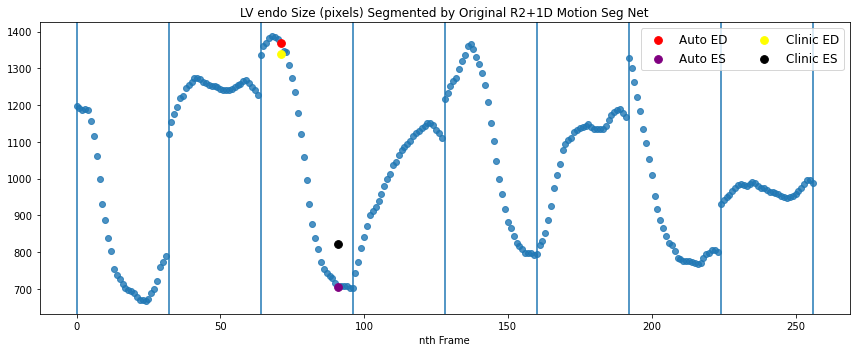

In [18]:
fig, ax = plt.subplots(1, figsize=(12, 5))

lv_sizes = np.sum(segmentations, axis=(1, 2)).ravel()

# if interpolate_last:
#     lv_sizes = lv_sizes.tolist()[:-32]
#     lv_sizes += interped_last_clip.tolist()

ax.scatter(np.arange(len(lv_sizes)), lv_sizes, alpha=0.8)

ax.scatter(ed_index, lv_sizes[ed_index],
            color="red", s=60, label="Auto ED")

ax.scatter(es_index, lv_sizes[es_index],
            color="purple", s=60, label="Auto ES")

ax.set_title("LV endo Size (pixels) Segmented by Original R2+1D Motion Seg Net")
ax.set_xlabel("nth Frame")

plt.scatter(ed_index, np.sum(ed_label), 
            s=60, color="yellow", label="Clinic ED")
plt.scatter(es_index, np.sum(es_label), 
            s=60, color="black", label="Clinic ES")
# bottom, top = plt.ylim()
# plt.ylim(bottom=200, top=top+200)

for i in range(0, len(lv_sizes), 32):
    ax.axvline(i, 0, 1)

plt.legend(fontsize=12, ncol=2)
plt.tight_layout()
plt.show()

In [19]:
one_array_segmentations = segmentations.reshape(-1, 112, 112)
print("ED LV Dice: {:.3f}".format(categorical_dice(one_array_segmentations[ed_index], ed_label, 1)))
print("ED LV Dice: {:.3f}".format(categorical_dice(one_array_segmentations[es_index], es_label, 1)))

ED LV Dice: 0.972
ED LV Dice: 0.905


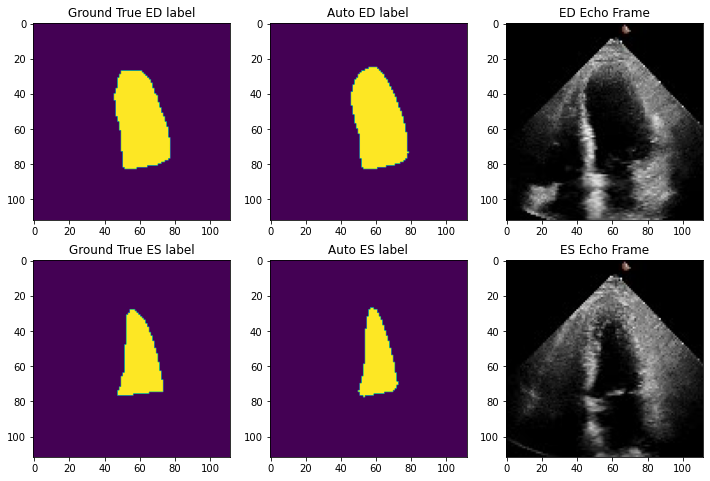

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0][0].set_title("Ground True ED label")
ax[0][0].imshow(ed_label)
ax[0][1].set_title("Auto ED label")
ax[0][1].imshow(one_array_segmentations[ed_index])
ax[0][2].set_title("ED Echo Frame")
ax[0][2].imshow(ed_frame.transpose([1, 2, 0]))

ax[1][0].set_title("Ground True ES label")
ax[1][0].imshow(es_label)
ax[1][1].set_title("Auto ES label")
ax[1][1].imshow(one_array_segmentations[es_index])
ax[1][2].set_title("ES Echo Frame")
ax[1][2].imshow(es_frame.transpose([1, 2, 0]))

# plt.tight_layout()
plt.show()

### Compute the Ejection Fraction

In [57]:
# from queue import SimpleQueue as squeue

def EDESpairs(diastole, systole):
    dframes = np.sort(np.array(diastole))
    sframes = np.sort(np.array(systole))
    clips = []
    
    inds = np.searchsorted(dframes, sframes, side='left')
    for i, sf in enumerate(sframes):
        if inds[i] == 0: # no prior diastolic frames for this sf
            continue
        best_df = diastole[inds[i]-1] # diastole frame nearest this sf.
        if len(clips) == 0 or best_df != clips[-1][0]:
            clips.append((best_df, sf))
            
    return clips

In [58]:
size = np.sum(segmentations, axis=(1, 2)).ravel()
_05cut, _85cut, _95cut = np.percentile(size, [5, 85, 95]) 

trim_min = _05cut
trim_max = _95cut
trim_range = trim_max - trim_min
systole = find_peaks(-size, distance=20, prominence=(0.50 * trim_range))[0]
diastole = find_peaks(size, distance=20, prominence=(0.50 * trim_range))[0]

# keep only real diastoles..
diastole = [x for x in diastole if size[x] >= _85cut]
# Add first frame
if np.mean(size[:3]) >= _85cut:
    diastole = [0] + diastole
diastole = np.array(diastole)

clip_pairs = EDESpairs(diastole, systole)

In [59]:
clip_pairs

[(0, 21), (35, 60), (72, 97)]

In [60]:
one_array_of_segmentations = segmentations.reshape(-1, 112, 112)

predicted_efs = []

for i in range(len(clip_pairs)):
    output_ED = one_array_of_segmentations[clip_pairs[i][0]]
    output_ES = one_array_of_segmentations[clip_pairs[i][1]]

    length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
    length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))

    edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
    esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

    ef_predicted = (edv - esv) / edv * 100
    
    predicted_efs.append(ef_predicted)
    
predicted_efs

[37.76919128188836, 40.20941768002248, 35.19632976864154]

In [61]:
# Use the ground true lables to derive the EF
output_ED = ed_label
output_ES = es_label

# Use the Simpson's Monoplane method
length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))

edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

ef_predicted = (edv - esv) / edv * 100

In [62]:
print("Average Derived EF: {:.2f}".format(np.mean(predicted_efs)))
print("True EF: {:16.2f}".format(EF)) 
print("Trace EF: {:15.2f} (EF Derived from Clinician's ED & ES labels using Simpson's monoplane method)".format(ef_predicted))

Average Derived EF: 37.72
True EF:            35.16
Trace EF:           36.31 (EF Derived from Clinician's ED & ES labels using Simpson's monoplane method)
